In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from torch.nn import Sequential as Sq
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.autograd as autograd
import argparse


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


class SwissRoll(torch.utils.data.Dataset):
    def __init__(self, n_samples=100000, noise=0.5):
        from sklearn.datasets import make_swiss_roll
        x = make_swiss_roll(n_samples=n_samples, noise=0.5)[0][:,[0, 2]]
        xmin, xmax = x.min(axis=0)[0], x.max(axis=0)[0]
        x = (x - xmin) / (xmax - xmin)
        self.x = torch.FloatTensor(2. * x - 1.)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

In [2]:
class Score(nn.Module):
    def __init__(self, x_dim=2, hidden_dim=256):
        super().__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim

        self.net = Sq(nn.Linear(x_dim, hidden_dim),
                      nn.GroupNorm(32, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.GroupNorm(32, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.GroupNorm(32, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, x_dim))

    def forward(self, x):
        return self.net(x)

In [9]:
dataset = SwissRoll()
score = Score()
optimizer = optim.Adam(score.parameters(), lr=1e-3)
loss_meter = AverageMeter()

In [10]:
loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

for epoch in range(50):
    loss_meter.reset()
    for x in loader:
        x.requires_grad_(True)
        optimizer.zero_grad()
        v = torch.randn_like(x)
        s = score(x)
        loss1 = 0.5 * (v * s).square().sum(dim=-1).mean()
        vs = (v * s).sum(dim=-1, keepdim=True)
        grad2 = autograd.grad(outputs=vs,
                              inputs=x,
                              grad_outputs=torch.ones_like(vs),
                              create_graph=True)[0]
        loss2 = (grad2 * v).sum(dim=-1).mean()
        loss = loss1 + loss2
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())
    print('[epoch %3d] | %s: %7.5f' % (epoch, 'loss', loss_meter.avg))

[epoch   0] | loss: -148.45204
[epoch   1] | loss: -253.90152
[epoch   2] | loss: -277.18511
[epoch   3] | loss: -287.84708
[epoch   4] | loss: -296.87059
[epoch   5] | loss: -297.03063
[epoch   6] | loss: -298.12825
[epoch   7] | loss: -301.17119
[epoch   8] | loss: -299.41525
[epoch   9] | loss: -299.41892
[epoch  10] | loss: -302.94096
[epoch  11] | loss: -303.51935
[epoch  12] | loss: -301.92813
[epoch  13] | loss: -307.73217
[epoch  14] | loss: -307.16072
[epoch  15] | loss: -308.76933
[epoch  16] | loss: -304.24263
[epoch  17] | loss: -313.01284
[epoch  18] | loss: -312.47061
[epoch  19] | loss: -311.24292
[epoch  20] | loss: -311.39747
[epoch  21] | loss: -311.16705
[epoch  22] | loss: -310.54594
[epoch  23] | loss: -314.95405
[epoch  24] | loss: -314.34282
[epoch  25] | loss: -314.25533
[epoch  26] | loss: -314.40418
[epoch  27] | loss: -312.82591
[epoch  28] | loss: -311.15669
[epoch  29] | loss: -316.51343
[epoch  30] | loss: -316.02513
[epoch  31] | loss: -315.28885
[epoch  

In [15]:
@torch.no_grad()
def langevin_dynamics(x, score, num_steps=1000, dt=0.01):
    chain = [x.detach().cpu().numpy()]
    dt = torch.tensor([dt]).to(x.device)
    for i in range(num_steps):
        dx = 0.5 * score(x) * dt + torch.randn_like(x) * dt.sqrt()
        x = x + dx
        chain += [x.detach().cpu().numpy()]

    return chain

In [16]:
num_samples = 10000
num_steps = 1000
dt = 0.0005
x = torch.randn(num_samples, 2)
chain = langevin_dynamics(x, score, num_steps, dt)

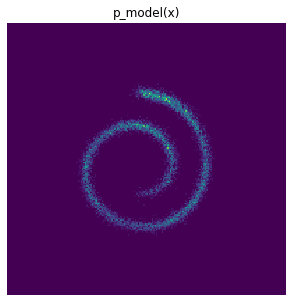

In [17]:
plt.figure(figsize=(5, 5))
plt.title('p_model(x)')
plt.hist2d(chain[-1][:,0],chain[-1][:,1], 200, range=((-2, 2), (-2, 2)))
plt.axis('off')
plt.show()